In [1]:
import glob
import matplotlib.pyplot
import matplotlib
import sys
import time
import math
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, iirnotch, filtfilt, firwin, argrelextrema

# enable zooming into graphs
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 5)

def pull_data(dir_name, file_name, separator=','):
    f = open(dir_name + '/' + file_name + '.csv')
    xs = []
    ys = []
    zs = []
    rs = []
    timestamps = []
    f.readline() # ignore header
    for line in f:
        value = line.split(separator)
        if len(value) > 3:
            t=value[1].strip()
            timestamps.append(t)
            x = float(value[2])
            y = float(value[3])
            z = float(value[4])
            r = math.sqrt(x ** 2 + y ** 2 + z ** 2)
            xs.append(x)
            ys.append(y)
            zs.append(z)
            rs.append(r)
    return np.array(xs), np.array(ys), np.array(zs), np.array(rs), np.array(timestamps)



In [2]:
def _separate_coordinates(window):
    x_coords = []
    y_coords = []
    z_coords = []
    coordinate_list = [x_coords, y_coords, z_coords]
    for i in range(0, 3):
        coordinate_list[i].extend(window[i])
 
    return coordinate_list
 
def compute_total_peaks(window):
    coordinate_list = _separate_coordinates(window)
 
    peak_arrays = []
    for i in coordinate_list:
        temp_array = np.array(i)
        peak_arrays.append(temp_array[argrelextrema(temp_array, np.greater)])
 
    peak_arrays_lengths = []
    for i in peak_arrays:
        peak_arrays_lengths.append(len(i))
 
    return peak_arrays_lengths
 
def compute_dfreq_range(window):
    coordinate_list = _separate_coordinates(window)
 
    ranges = [0, 0, 0]
    for i in range(0, 3):
        ranges[i] = max(coordinate_list[i]) - min(coordinate_list[i])
 
    return ranges
 
def extract_features(window):
   
    x = []
    feature_names = []
   
    x.append(compute_total_peaks(window))
    feature_names.append(["x_peaks", "y_peaks", "z_peaks"])
   
    x.append(compute_dfreq_range(window))
    feature_names.append(["x_dfreqs", "y_dfreqs", "z_dfreqs"])
 
    return feature_names, x

<IPython.core.display.Javascript object>


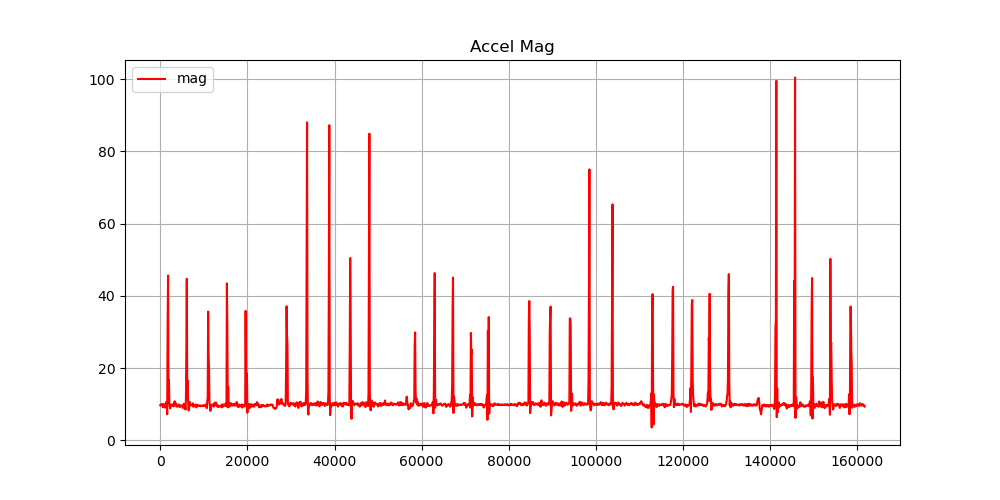

In [3]:
#Back hand throws (supposed to be 25)
b25_raw_data = pull_data('data', 'WomboCombo_accel_3')
(b25_accel_x, b25_accel_y, b25_accel_z, b25_accel_mag, b25_accel_time_temp) = b25_raw_data

b25_accel_time = b25_accel_time_temp.astype(int)

# start timestamps from zero (assume timestamps are in milliseconds)
plt.figure(figsize=(10,5))
plt.plot(b25_accel_time, b25_accel_mag, 'r-',label="mag")
#plt.plot(b25_accel_time, b25_accel_x, 'g-',label="x")
#plt.plot(b25_accel_time, b25_accel_y, 'b-',label="y")
#plt.plot(b25_accel_time, b25_accel_z, 'y-',label="z")
plt.title("Accel Mag")
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

In [4]:
def maape(a, p):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    EPSILON = 1e-10
    actual = np.array(a)
    predicted = np.array(p)
    return np.round(np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON)))),3)*100

#Takes in a number and an array of numbers. Finds the index of the number in the array that is closest to the given number.
def find_closest_to_number(number_of_interest, array):
    current_smallest_difference = math.inf
    index_to_return = -1
 
    for i, number in enumerate(array):
        difference = abs(float(number_of_interest) - float(number))
        if (difference <= current_smallest_difference):
            current_smallest_difference = difference
            index_to_return = i+1
 
    return index_to_return
 
def timestamps_array(mag, time):
    fs_average = sum(mag) / (len(mag) / 2)
 
    peak_arr = mag[argrelextrema(mag, np.greater)]
 
    peaks = []
    times = []
 
    for y in peak_arr:
        if y > fs_average:
            peaks.append(y)
    
    print(str(len(peaks)) + " throws found. Expected 30.")
    
    for x in peaks:
        times.append(int(time[np.where(mag == x)]))
    
    return times


In [5]:
FOREHAND = 0
BACKHAND = 0
HAMMER = 0
 
EXPECTED = [10,10,10]

grav_data = pull_data('data', 'WomboCombo_grav_3')
 
(grav_x, grav_y, grav_z, grav_mag, grav_time) = grav_data
timestamps = timestamps_array(b25_accel_mag, b25_accel_time)

def determine_throw_type(timestamp_array):
    global FOREHAND
    global BACKHAND
    global HAMMER
    for timestamp in timestamp_array:
        index = find_closest_to_number(timestamp, grav_time)

        grav_x_value = grav_x[index]
        grav_y_value = grav_y[index]
        grav_z_value = grav_z[index]
        
        if (grav_x_value < 0 and grav_z_value < -2.0 and grav_y_value < 2.5):
            BACKHAND += 1
        elif (grav_z_value < 0 and grav_y_value >= 2.5):
            FOREHAND += 1
        elif (grav_z_value >= 0):
            HAMMER += 1

determine_throw_type(timestamps)
 
print(str(FOREHAND) + " forehand throws were performed. Expected: " + str(EXPECTED[0]) +" Error: " + str(maape(EXPECTED[0], FOREHAND)) + "%")
print(str(BACKHAND) + " backhand throws were performed. Expected: " + str(EXPECTED[1]) +" Error: " + str(maape(EXPECTED[1], BACKHAND)) + "%")
print(str(HAMMER) + " hammer throws were performed. Expected: " + str(EXPECTED[2]) +" Error: " + str(maape(EXPECTED[2], HAMMER)) + "%")


35 throws found. Expected 30.
13 forehand throws were performed. Expected: 10 Error: 29.099999999999998%
10 backhand throws were performed. Expected: 10 Error: 0.0%
12 hammer throws were performed. Expected: 10 Error: 19.7%
